In [1]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass

# Simple Oscillators

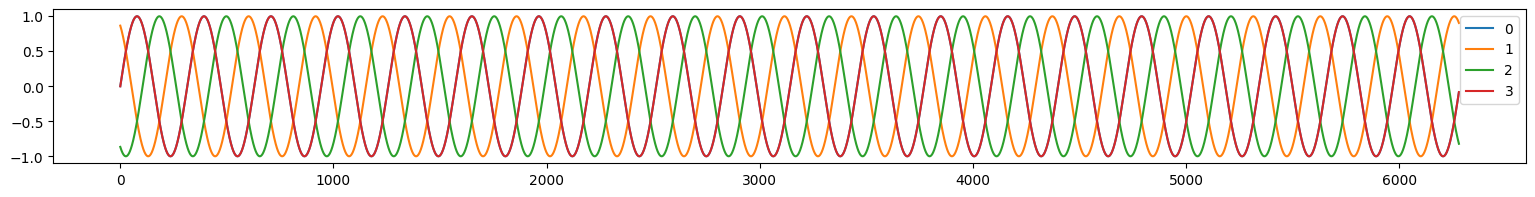

In [2]:
class SimpleOscillators:
    def __init__(self, frequencies, phases, dt):
        self.frequencies = frequencies  # (n,)
        self.dt = dt
        self.phases = phases.copy()  # (n,)
        
    def __call__(self):
        value = np.sin(self.phases)

        d_phase = self.frequencies   # <-- vanilla oscillators way
        self.phases += d_phase * self.dt

        return value

n = 4
T = 2 * np.pi
oscillators = SimpleOscillators(
    frequencies=np.ones((n,)) * 2, 
    phases=np.linspace(start=0, stop=2 * np.pi, num=n), 
    dt=0.01,
)
waves = np.array([oscillators() for _ in range(10 * int(T / oscillators.dt))])

plt.figure(figsize=(19, 2))
for i in range(n):
    plt.plot(waves[:, i], label=i)
plt.legend()

# Slowly building the CPG module

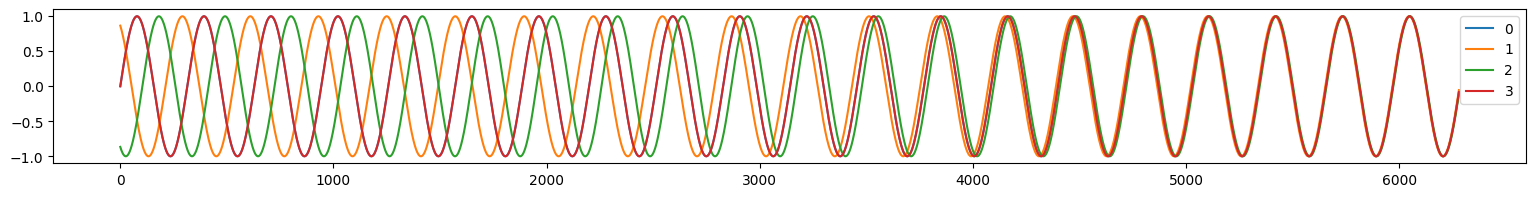

In [3]:
class SimpleKuramotoOscillators:
    def __init__(self, frequencies, phases, dt, coupling_strength):
        self.frequencies = frequencies  # (n,)
        self.dt = dt
        self.coupling_strength = coupling_strength
        self.phases = phases.copy()  # (n,)
        
    def __call__(self):
        value = np.sin(self.phases)

        # d_phase = self.frequencies   # <-- vanilla oscillators way
        d_phase = self.frequencies + (
            self.coupling_strength / len(self.frequencies) 
            * np.sin(self.phases - self.phases[:, np.newaxis])
        ).sum(axis=1)

        self.phases += d_phase * self.dt

        return value

n = 4
T = 2 * np.pi
oscillators = SimpleKuramotoOscillators(
    frequencies=np.ones((n,)) * 2, 
    phases=np.linspace(start=0, stop=2 * np.pi, num=n), 
    dt=0.01,
    coupling_strength=0.1,
)
waves = np.array([oscillators() for _ in range(10 * int(T / oscillators.dt))])

plt.figure(figsize=(19, 2))
for i in range(n):
    plt.plot(waves[:, i], label=i)
plt.legend()

# Adding phase bias

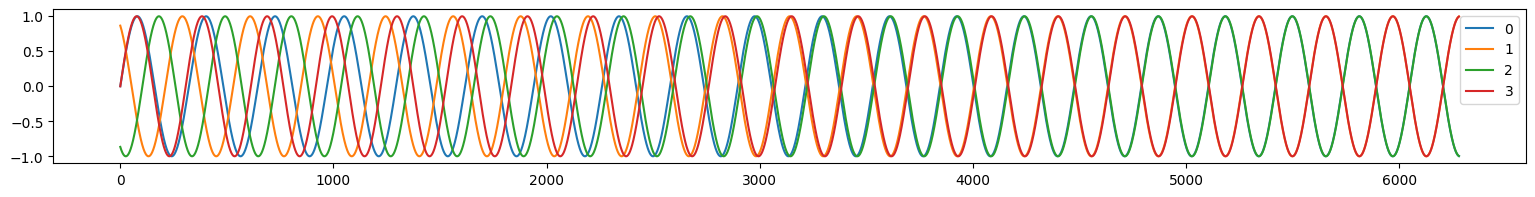

In [4]:
class SimpleKuramotoOscillators:
    def __init__(self, frequencies, phases, dt, coupling_strength, phase_bias):
        self.frequencies = frequencies  # (n,)
        self.dt = dt
        self.coupling_strength = coupling_strength
        self.phases = phases.copy()  # (n,)
        self.phase_bias = phase_bias  # (n, n) Skew Symmetric
        
    def __call__(self):
        value = np.sin(self.phases)

        # d_phase = self.frequencies   # <-- vanilla oscillators way
        d_phase = self.frequencies + (
            self.coupling_strength / len(self.frequencies) 
            * np.sin(self.phases - self.phases[:, np.newaxis] - self.phase_bias)
        ).sum(axis=1)

        self.phases += d_phase * self.dt

        return value

n = 4
T = 2 * np.pi
oscillators = SimpleKuramotoOscillators(
    frequencies=np.ones((n,)) * 2, 
    phases=np.linspace(start=0, stop=2 * np.pi, num=n), 
    dt=0.01,
    coupling_strength=0.1,
    phase_bias=np.array([
        [0, np.pi, 0, np.pi],
        [-np.pi, 0, np.pi, 0],
        [0, -np.pi, 0, np.pi],
        [-np.pi, 0, -np.pi, 0],
    ]),
)
waves = np.array([oscillators() for _ in range(10 * int(T / oscillators.dt))])

plt.figure(figsize=(19, 2))
for i in range(n):
    plt.plot(waves[:, i], label=i)
plt.legend()

# Adding vertical offset (B)

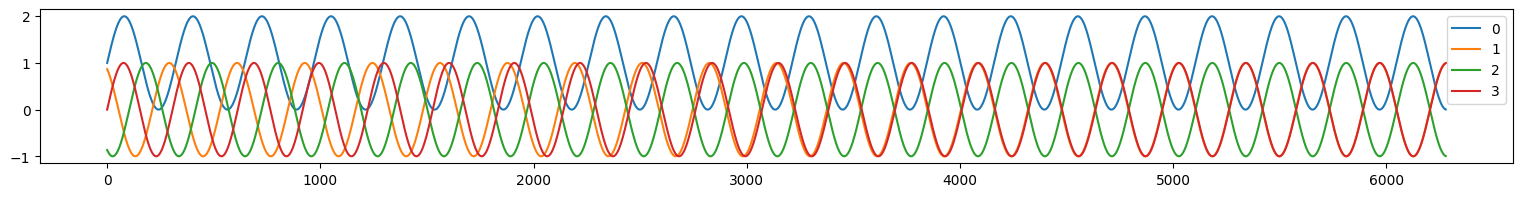

In [5]:
class SimpleKuramotoOscillators:
    def __init__(self, frequencies, phases, dt, coupling_strength, phase_bias):
        self.frequencies = frequencies  # (n,)
        self.dt = dt
        self.coupling_strength = coupling_strength
        self.phases = phases.copy()  # (n,)
        self.phase_bias = phase_bias  # (n, n) Skew Symmetric
        
    def __call__(self):
        offset = np.array([1, 0, 0, 0])
        
        value = offset + np.sin(self.phases)

        # d_phase = self.frequencies   # <-- vanilla oscillators way
        d_phase = self.frequencies + (
            self.coupling_strength / len(self.frequencies) 
            * np.sin(self.phases - self.phases[:, np.newaxis] - self.phase_bias)
        ).sum(axis=1)

        self.phases += d_phase * self.dt

        return value

n = 4
T = 2 * np.pi
oscillators = SimpleKuramotoOscillators(
    frequencies=np.ones((n,)) * 2, 
    phases=np.linspace(start=0, stop=2 * np.pi, num=n), 
    dt=0.01,
    coupling_strength=0.1,
    phase_bias=np.array([
        [0, np.pi, 0, np.pi],
        [-np.pi, 0, np.pi, 0],
        [0, -np.pi, 0, np.pi],
        [-np.pi, 0, -np.pi, 0],
    ]),
)
waves = np.array([oscillators() for _ in range(10 * int(T / oscillators.dt))])

plt.figure(figsize=(19, 2))
for i in range(n):
    plt.plot(waves[:, i], label=i)
plt.legend()

# How does dB and ddB affect the oscillators?

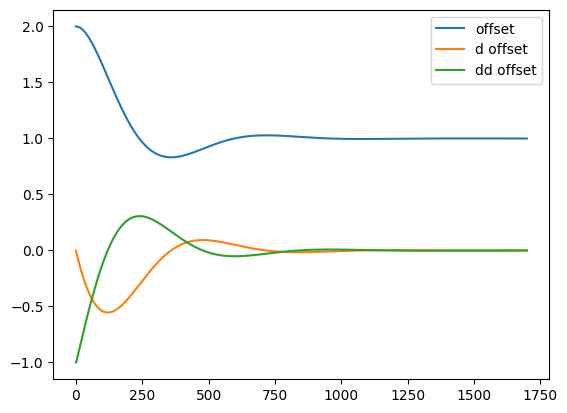

In [6]:
desired_offset = 1
current_offset = 2
current_offset_d = 0
current_offset_dd = 0
dt = 0.01
T = 17

alpha_offset = 1  # Higher makes current_offset converge smoothly. < 0 makes it oscillate.
beta_offset = 1  # Higher makes current_offset_d oscillate before converging. < 0 makes it smooth
alpha_desired_offset = 1  # Set this to motor limits. Simply scales the amplitude by this.

current_offset_list = []
current_offset_d_list = []
current_offset_dd_list = []

for i in range(int(T / dt)):

    _current_offset_dd = alpha_offset * (
        beta_offset 
        * (
            alpha_desired_offset 
            * desired_offset 
            - current_offset
        ) 
        - current_offset_d
    )
    current_offset += current_offset_d * dt
    current_offset_d += current_offset_dd * dt
    
    current_offset_dd = _current_offset_dd
    
    current_offset_list.append(current_offset)
    current_offset_d_list.append(current_offset_d)
    current_offset_dd_list.append(current_offset_dd)
    
plt.plot(current_offset_list, label="offset")
plt.plot(current_offset_d_list, label="d offset")
plt.plot(current_offset_dd_list, label="dd offset")
plt.legend()

# Adding scheduler for offset.

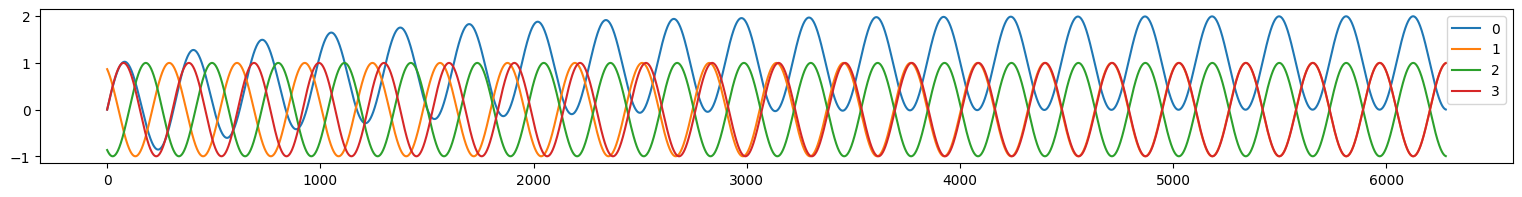

In [7]:
class SimpleKuramotoOscillators:
    @dataclass
    class CoEff:
        alpha_offset = 1  # Higher makes current_offset converge smoothly.
        beta_offset = 0.1  # Higher makes current_offset_d oscillate before converging.

    def __init__(self, frequencies, phases, dt, coupling_strength, phase_bias, desired_offset, co_effs: CoEff,):
        self.c = co_effs
        self.frequencies = frequencies  # (n,)
        self.dt = dt
        self.coupling_strength = coupling_strength
        self.phases = phases.copy()  # (n,)
        self.phase_bias = phase_bias  # (n, n) Skew Symmetric
        self.desired_offset = desired_offset  # (n,)

        self.current_offset = np.zeros_like(phases)  # (n,)
        self.offset_d = np.zeros_like(phases)  # (n,)
        self.offset_dd = np.zeros_like(phases)  # (n,)
        
    def __call__(self):
        value = self.current_offset + np.sin(self.phases)

        # d_phase = self.frequencies   # <-- vanilla oscillators way
        d_phase = self.frequencies + (
            self.coupling_strength / len(self.frequencies) 
            * np.sin(self.phases - self.phases[:, np.newaxis] - self.phase_bias)
        ).sum(axis=1)
        self.phases += d_phase * self.dt
        
        # Offset update
        _offset_dd = self.c.alpha_offset * (self.c.beta_offset * (self.desired_offset - self.current_offset) - self.offset_d)
        self.current_offset += self.offset_d * self.dt
        self.offset_d += self.offset_dd * self.dt
        self.offset_dd = _offset_dd

        return value

n = 4
T = 2 * np.pi
oscillators = SimpleKuramotoOscillators(
    frequencies=np.ones((n,)) * 2, 
    phases=np.linspace(start=0, stop=2 * np.pi, num=n), 
    dt=0.01,
    coupling_strength=0.1,
    phase_bias=np.array([
        [0, np.pi, 0, np.pi],
        [-np.pi, 0, np.pi, 0],
        [0, -np.pi, 0, np.pi],
        [-np.pi, 0, -np.pi, 0],
    ]),
    desired_offset=np.array([1, 0, 0, 0]),
    co_effs=SimpleKuramotoOscillators.CoEff(),
)
waves = np.array([oscillators() for _ in range(10 * int(T / oscillators.dt))])

plt.figure(figsize=(19, 2))
for i in range(n):
    plt.plot(waves[:, i], label=i)
plt.legend()

# Adding amplitude change

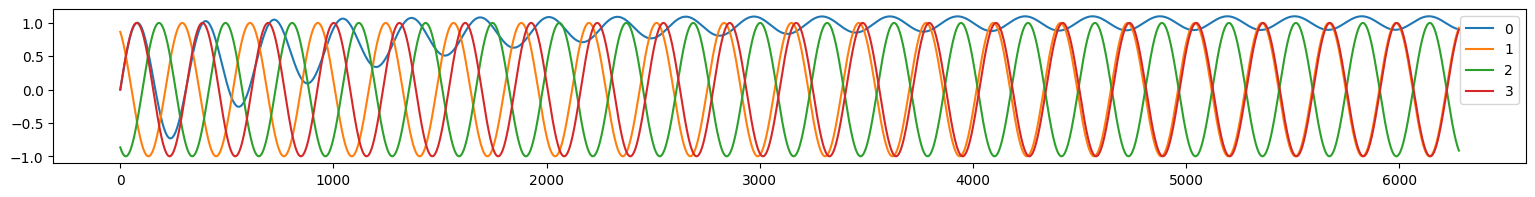

In [8]:
class SimpleKuramotoOscillators:
    @dataclass
    class CoEff:
        alpha_frequency = 1
        alpha_coupling_strength = 1
        alpha_phase_bias = 1
        
        alpha_offset = 1  # Higher makes current_offset converge smoothly.
        beta_offset = 0.1  # Higher makes current_offset_d oscillate before converging.
        alpha_desired_offset = 1  # Simply scales the offset by this.

        alpha_amplitude = 1  # Higher makes current_offset converge smoothly.
        beta_amplitude = 0.1  # Higher makes current_offset_d oscillate before converging.
        alpha_desired_amplitude = 1  # Set this to motor limits. Simply scales the amplitude by this.

    def __init__(
        self,
        frequencies,
        phases,
        dt,
        coupling_strength,
        phase_bias,
        desired_amplitude,
        desired_offset,
        co_effs: CoEff,
    ):
        self.c = co_effs
        self.frequencies = frequencies  # (n,)
        self.dt = dt
        self.coupling_strength = coupling_strength  # (n, n)
        self.phases = phases.copy()  # (n,)
        self.phase_bias = phase_bias  # (n, n) Skew Symmetric
        self.desired_amplitude = desired_amplitude  # (n,)
        self.desired_offset = desired_offset  # (n,)

        self.current_offset = np.zeros_like(phases)  # (n,)
        self.offset_d = np.zeros_like(phases)  # (n,)
        self.offset_dd = np.zeros_like(phases)  # (n,)

        self.current_amplitude = np.ones_like(phases)  # (n,)
        self.amplitude_d = np.zeros_like(phases)  # (n,)
        self.amplitude_dd = np.zeros_like(phases)  # (n,)

    def __call__(self):
        value = self.current_offset + self.current_amplitude * np.sin(self.phases)

        d_phase = self.c.alpha_frequency * self.frequencies + (
            self.current_amplitude
            * self.c.alpha_coupling_strength
            * self.coupling_strength
            * np.sin(
                self.phases
                - self.phases[:, np.newaxis]
                - (self.c.alpha_phase_bias * self.phase_bias)
            )
        ).sum(axis=1)
        self.phases += d_phase * self.dt

        # Amplitude update
        _amplitude_dd = self.c.alpha_amplitude * (
            self.c.beta_amplitude
            * (
                self.c.alpha_desired_amplitude * self.desired_amplitude
                - self.current_amplitude
            )
            - self.amplitude_d
        )
        self.current_amplitude += self.amplitude_d * self.dt
        self.amplitude_d += self.amplitude_dd * self.dt
        self.amplitude_dd = _amplitude_dd

        # Offset update
        _offset_dd = self.c.alpha_offset * (
            self.c.beta_offset
            * (self.c.alpha_desired_offset * self.desired_offset - self.current_offset)
            - self.offset_d
        )
        self.current_offset += self.offset_d * self.dt
        self.offset_d += self.offset_dd * self.dt
        self.offset_dd = _offset_dd

        return value


n = 4
T = 2 * np.pi
oscillators = SimpleKuramotoOscillators(
    frequencies=np.ones((n,)) * 2,
    phases=np.linspace(start=0, stop=2 * np.pi, num=n),
    dt=0.01,
    coupling_strength=0.02 * np.ones((n, n)),
    phase_bias=np.array(
        [
            [0, np.pi, 0, np.pi],
            [-np.pi, 0, np.pi, 0],
            [0, -np.pi, 0, np.pi],
            [-np.pi, 0, -np.pi, 0],
        ]
    ),
    desired_amplitude=np.array([0.1, 1, 1, 1]),
    desired_offset=np.array([1, 0, 0, 0]),
    co_effs=SimpleKuramotoOscillators.CoEff(),
)
waves = np.array([oscillators() for _ in range(10 * int(T / oscillators.dt))])

plt.figure(figsize=(19, 2))
for i in range(n):
    plt.plot(waves[:, i], label=i)
plt.legend()

# Different coupling strength.

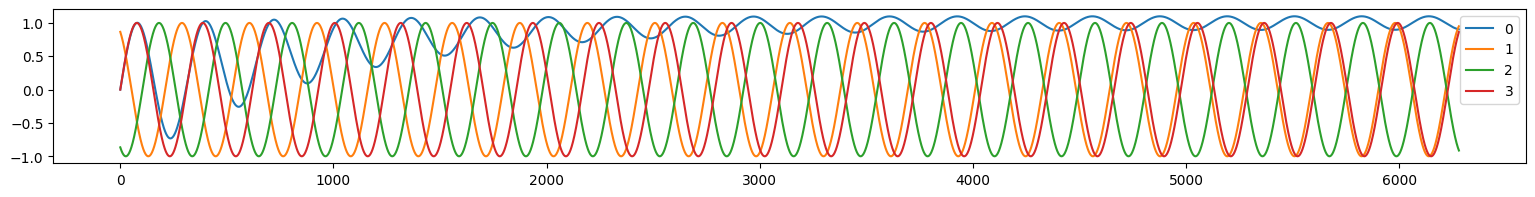

In [9]:
class KuramotoOscillators:
    @dataclass
    class CoEff:
        alpha_frequency = 1
        alpha_coupling_strength = 1
        alpha_phase_bias = 1
        
        alpha_offset = 1  # Higher makes current_offset converge smoothly.
        beta_offset = 0.1  # Higher makes current_offset_d oscillate before converging.
        alpha_desired_offset = 1  # Simply scales the offset by this.

        alpha_amplitude = 1  # Higher makes current_offset converge smoothly.
        beta_amplitude = 0.1  # Higher makes current_offset_d oscillate before converging.
        alpha_desired_amplitude = 1  # Set this to motor limits. Simply scales the amplitude by this.

    def __init__(
        self,
        frequencies,
        phases,
        dt,
        coupling_strength,
        phase_bias,
        desired_amplitude,
        desired_offset,
        co_effs: CoEff,
    ):
        self.c = co_effs
        self.frequencies = frequencies  # (n,)
        self.dt = dt
        self.coupling_strength = coupling_strength  # (n, n) Symmetric
        self.phases = phases.copy()  # (n,)
        self.phase_bias = phase_bias  # (n, n) Skew Symmetric
        
        self.desired_amplitude = desired_amplitude  # (n,)
        self.current_amplitude = np.ones_like(phases)  # (n,)
        self.amplitude_d = np.zeros_like(phases)  # (n,)
        self.amplitude_dd = np.zeros_like(phases)  # (n,)
        
        self.desired_offset = desired_offset  # (n,)
        self.current_offset = np.zeros_like(phases)  # (n,)
        self.offset_d = np.zeros_like(phases)  # (n,)
        self.offset_dd = np.zeros_like(phases)  # (n,)

    def __call__(self):
        value = self.current_offset + self.current_amplitude * np.sin(self.phases)

        d_phase = self.c.alpha_frequency * self.frequencies + (
            self.current_amplitude
            * self.c.alpha_coupling_strength
            * self.coupling_strength
            * np.sin(
                self.phases
                - self.phases[:, np.newaxis]
                - (self.c.alpha_phase_bias * self.phase_bias)
            )
        ).sum(axis=1)
        self.phases += d_phase * self.dt

        # Amplitude update
        _amplitude_dd = self.c.alpha_amplitude * (
            self.c.beta_amplitude
            * (
                self.c.alpha_desired_amplitude * self.desired_amplitude
                - self.current_amplitude
            )
            - self.amplitude_d
        )
        self.current_amplitude += self.amplitude_d * self.dt
        self.amplitude_d += self.amplitude_dd * self.dt
        self.amplitude_dd = _amplitude_dd

        # Offset update
        _offset_dd = self.c.alpha_offset * (
            self.c.beta_offset
            * (self.c.alpha_desired_offset * self.desired_offset - self.current_offset)
            - self.offset_d
        )
        self.current_offset += self.offset_d * self.dt
        self.offset_d += self.offset_dd * self.dt
        self.offset_dd = _offset_dd

        return value


n = 4
T = 2 * np.pi
oscillators = KuramotoOscillators(
    frequencies=np.ones((n,)) * 2,
    phases=np.linspace(start=0, stop=2 * np.pi, num=n),
    dt=0.01,
    coupling_strength=np.array(
        [
            [1, 1, 1, 1],
            [1, 1, 1, 0.5],
            [1, 1, 1, 1],
            [1, 0.5, 1, 1],
        ]
    ) * 0.02,
    phase_bias=np.array(
        [
            [0, np.pi, 0, np.pi],
            [-np.pi, 0, np.pi, 0],
            [0, -np.pi, 0, np.pi],
            [-np.pi, 0, -np.pi, 0],
        ]
    ),
    desired_amplitude=np.array([0.1, 1, 1, 1]),
    desired_offset=np.array([1, 0, 0, 0]),
    co_effs=KuramotoOscillators.CoEff(),
)
waves = np.array([oscillators() for _ in range(10 * int(T / oscillators.dt))])

plt.figure(figsize=(19, 2))
for i in range(n):
    plt.plot(waves[:, i], label=i)
plt.legend()

# Testing change in frequencies

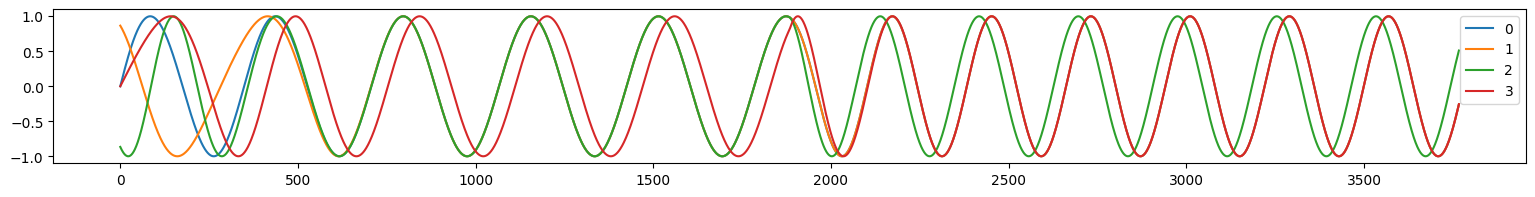

In [10]:
class KuramotoOscillators:
    @dataclass
    class CoEff:
        alpha_frequency = 1
        alpha_coupling_strength = 1
        alpha_phase_bias = 1
        
        alpha_offset = 1  # Higher makes current_offset converge smoothly.
        beta_offset = 0.1  # Higher makes current_offset_d oscillate before converging.
        alpha_desired_offset = 1  # Simply scales the offset by this.

        alpha_amplitude = 1  # Higher makes current_offset converge smoothly.
        beta_amplitude = 0.1  # Higher makes current_offset_d oscillate before converging.
        alpha_desired_amplitude = 1  # Set this to motor limits. Simply scales the amplitude by this.

    def __init__(
        self,
        frequencies,
        phases,
        dt,
        coupling_strength,
        phase_bias,
        desired_amplitude,
        desired_offset,
        co_effs: CoEff,
    ):
        self.c = co_effs
        self.frequencies = frequencies  # (n,)
        self.dt = dt
        self.coupling_strength = coupling_strength  # (n, n) Symmetric
        self.phases = phases.copy()  # (n,)
        self.phase_bias = phase_bias  # (n, n) Skew Symmetric
        
        self.desired_amplitude = desired_amplitude  # (n,)
        self.current_amplitude = np.ones_like(phases)  # (n,)
        self.amplitude_d = np.zeros_like(phases)  # (n,)
        self.amplitude_dd = np.zeros_like(phases)  # (n,)
        
        self.desired_offset = desired_offset  # (n,)
        self.current_offset = np.zeros_like(phases)  # (n,)
        self.offset_d = np.zeros_like(phases)  # (n,)
        self.offset_dd = np.zeros_like(phases)  # (n,)

    def __call__(self):
        value = self.current_offset + self.current_amplitude * np.sin(self.phases)

        d_phase = self.c.alpha_frequency * self.frequencies + (
            self.current_amplitude
            * self.c.alpha_coupling_strength
            * self.coupling_strength
            * np.sin(
                self.phases
                - self.phases[:, np.newaxis]
                - (self.c.alpha_phase_bias * self.phase_bias)
            )
        ).sum(axis=1)
        self.phases += d_phase * self.dt

        # Amplitude update
        _amplitude_dd = self.c.alpha_amplitude * (
            self.c.beta_amplitude
            * (
                self.c.alpha_desired_amplitude * self.desired_amplitude
                - self.current_amplitude
            )
            - self.amplitude_d
        )
        self.current_amplitude += self.amplitude_d * self.dt
        self.amplitude_d += self.amplitude_dd * self.dt
        self.amplitude_dd = _amplitude_dd

        # Offset update
        _offset_dd = self.c.alpha_offset * (
            self.c.beta_offset
            * (self.c.alpha_desired_offset * self.desired_offset - self.current_offset)
            - self.offset_d
        )
        self.current_offset += self.offset_d * self.dt
        self.offset_d += self.offset_dd * self.dt
        self.offset_dd = _offset_dd

        return value


n = 4
T = 2 * np.pi
oscillators = KuramotoOscillators(
    frequencies=np.array([1, 1, 1, 0.5]) * 2,
    phases=np.linspace(start=0, stop=2 * np.pi, num=n),
    dt=0.01,
    coupling_strength=np.ones((n, n)) * 0.35,
    phase_bias=np.zeros((n, n)),
    desired_amplitude=np.ones((n,)),
    desired_offset=np.zeros((n,)),
    co_effs=KuramotoOscillators.CoEff(),
)
waves = np.array([oscillators() for _ in range(3 * int(T / oscillators.dt))])
oscillators.frequencies = np.array([1, 1, 1.5, 1]) * 2
waves2 = np.array([oscillators() for _ in range(3 * int(T / oscillators.dt))])

waves = np.concatenate([waves, waves2], axis=0)

plt.figure(figsize=(19, 2))
for i in range(n):
    plt.plot(waves[:, i], label=i)
plt.legend()